# IBM Data Science Professional Certificate Capstone Project

## Introduction

### Description:

**_Using geospatial, population and demographic data, what is the most appealing venue type to open up in each borough of the greater London area?_**

### Business Problem:
A property developer has just finished construction on locations in each of the 33 London boroughs. The developer is interested in knowing what are the best businesses to open at these new locations. They would like to identify which boroughs are similar to each other, identify the most frequently occurring businesses within each similar boroughs group, and identify businesses to open in each borough with this information. The developer would like to utilize demographic data, political data, median salary data, and religious make-up for each borough to identify similarity between boroughs. With those similar boroughs identified, the developer would then like to use venue data on businesses within each borough.


### Project aims:
The goal of this project is to identify similar boroughs within the London area using clustering techniques. Once boroughs have been clustered into groups, individual boroughs will be looked at to identify which venue type is lacking in respect to the cluster group, to give insight into what type of venue should be opened up within each borough.

## Data:
For demographic, political, salary, and religious data, publicly open available data online will be gathered.


[Borough names, political, Area, Population, and Co-ordinates data](https://en.wikipedia.org/wiki/List_of_London_boroughs)

[Ethnicity data](https://en.wikipedia.org/wiki/Demography_of_London)

[Age data](https://data.london.gov.uk/dataset/office-national-statistics-ons-population-estimates-borough)

[Salary data](https://data.london.gov.uk/dataset/earnings-place-residence-borough)


Geo data will be pulled using the FourSquare API. Web scraping will be used to gather population and demographic information for each borough within the greater London area.

[Venue data](https://foursquare.com/)

## Methodology

The exploratory data analysis for each data set can be found below. Once the data was collected it was all cleaned and stored into a single Data Frame. Some of the data came in different formats so this all had to be accounted for. Every time data was collected it was observed for missing values using the missingno library. Once all the data was collected and scaled, **K-means** algorithm was used to generate similar boroughs within London based upon the demographic, political, income, and age data collected.

Once the clusters were established, then the FourSquare API was used to pull venue data within each neighborhood. The top frequently occuring venue types within each cluster were then compared to the top frequently occuring venues within each borough that fell within the respective cluster. Comparison was made to identify the most desireable venues to build within each borough.

### The Notebook and Code:
First import some libraries

In [391]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import os
from geopy.geocoders import Nominatim
import folium
import urllib, json
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import missingno as msno

print('Libraries have imported successfully')

Libraries have imported successfully


### Borough Data:
First the borough data will be imported with web scraping public tables. First the borough names, political control, population, and co-ordinates are pulled off of Wikipedia

In [392]:
url_londonBorough = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
table_id = "wikitable sortable"

response = requests.get(url_londonBorough)
soup = BeautifulSoup(response.text, 'html.parser')

borough_soup = soup.findAll('table',{ "class" : table_id})
df = pd.read_html(str(borough_soup))
df_london = df[0]
df_london.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


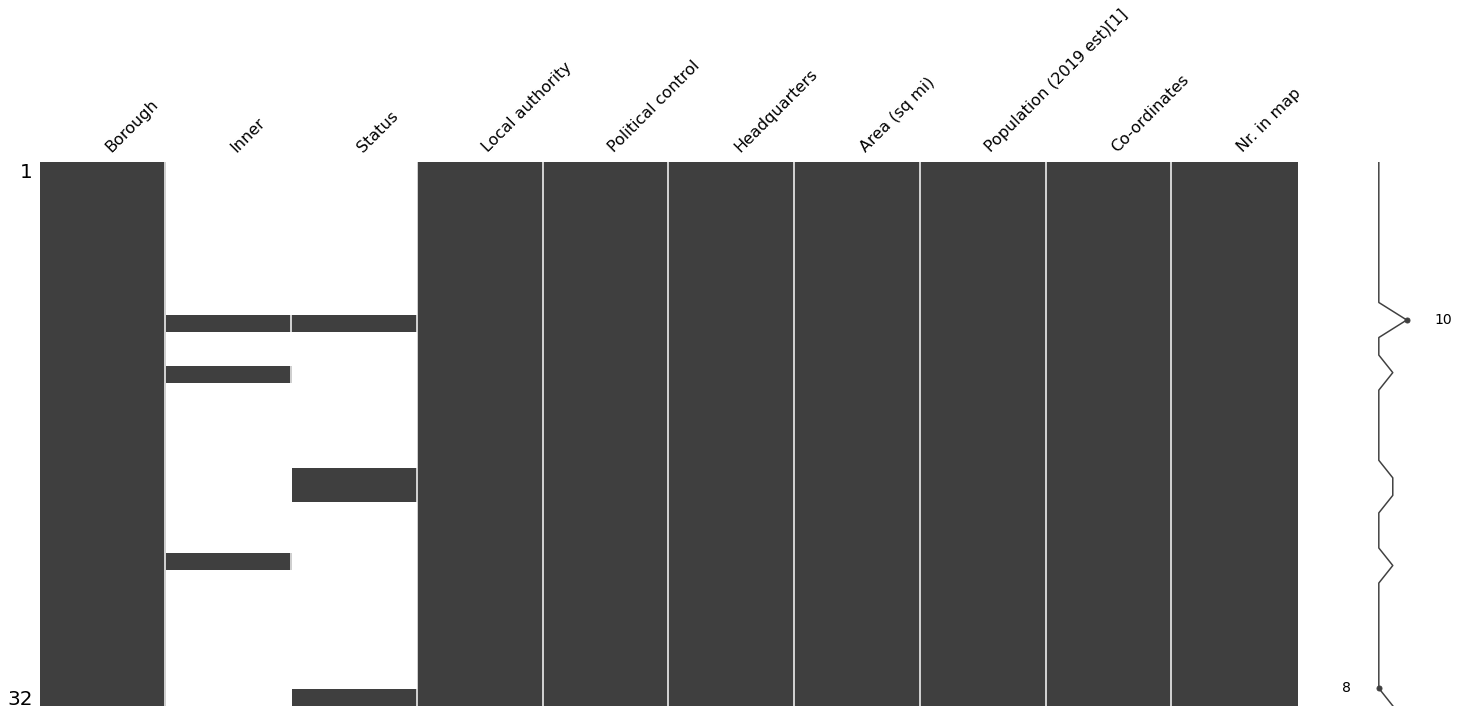

In [393]:
msno.matrix(df_london)

First we'll drop columns we don't need, and clean up the data within each of the columns we have left.

In [394]:
df_london.drop(columns=['Inner', 'Status', 'Local authority', 'Headquarters'], inplace=True)

In [395]:
print(df_london['Borough'])

0       Barking and Dagenham [note 1]
1                              Barnet
2                              Bexley
3                               Brent
4                             Bromley
5                              Camden
6                             Croydon
7                              Ealing
8                             Enfield
9                  Greenwich [note 2]
10                            Hackney
11    Hammersmith and Fulham [note 4]
12                           Haringey
13                             Harrow
14                           Havering
15                         Hillingdon
16                           Hounslow
17                          Islington
18             Kensington and Chelsea
19               Kingston upon Thames
20                            Lambeth
21                           Lewisham
22                             Merton
23                             Newham
24                          Redbridge
25               Richmond upon Thames
26          

We can see a few of the Borough names contain unwanted substrings so we will remove those substrings. Also we will put the longitude and latitude into their own columns. After that we will rename the columns for ease of use.

In [396]:
df_london['Borough'] = df_london['Borough'].str.replace('\[note [1-9]{1}]','')
df_london['Borough'] = df_london['Borough'].str.rstrip()
df_london['Co-ordinates'] = df_london['Co-ordinates'].str.replace('°', '.')

In [397]:
df_london['Co-ordinates'] = df_london['Co-ordinates'].str.split()

In [398]:
df_london['Longitude'] = df_london['Co-ordinates'].str[-1]
df_london['Latitude'] = df_london['Co-ordinates'].str[-2]

In [399]:
df_london.Latitude = df_london.Latitude.str.replace('.N', '')
df_london.Longitude = df_london.Longitude.str.replace('.E', '')
df_london.Longitude = df_london.Longitude.str.replace('.W', '-')

In [400]:
df_london['Longitude'] = df_london['Longitude'].str.replace('\\ufeff', '')
df_london['Latitude'] = df_london['Latitude'].str.replace('\\ufeff', '')

In [401]:
df_london['Longitude'] = df_london.Longitude.mask(df_london.Longitude.str[-1].isin(['-']), df_london.Longitude.str[-1].str.cat(df_london.Longitude.str[:-1])).astype('float')

In [402]:
df_london['Latitude'] = df_london['Latitude'].astype('float')

In [403]:
df_london.rename(columns={'Political control': 'Party', 'Area (sq mi)': 'Area', 'Population (2019 est)[1]': 'Population'}, inplace=True)
df_london.head()

,Borough,Party,Area,Population,Co-ordinates,Nr. in map,Longitude,Latitude
0,Barking and Dagenham,Labour,13.93,212906,"[.mw-parser-output, .geo-default,.mw-parser-ou...",25,0.1557,51.5607
1,Barnet,Conservative,33.49,395896,"[51.37′31″N, 0.09′06″W﻿, /, ﻿51.6252.N, 0.1517.W]",31,-0.1517,51.6252
2,Bexley,Conservative,23.38,248287,"[51.27′18″N, 0.09′02″E﻿, /, ﻿51.4549.N, 0.1505.E]",23,0.1505,51.4549
3,Brent,Labour,16.70,329771,"[51.33′32″N, 0.16′54″W﻿, /, ﻿51.5588.N, 0.2817.W]",12,-0.2817,51.5588
4,Bromley,Conservative,57.97,332336,"[51.24′14″N, 0.01′11″E﻿, /, ﻿51.4039.N, 0.0198.E]",20,0.0198,51.4039


In [404]:
df_london.drop(columns=['Co-ordinates', 'Nr. in map'], inplace=True)

In [405]:
df_london.head()

,Borough,Party,Area,Population,Longitude,Latitude
0,Barking and Dagenham,Labour,13.93,212906,0.1557,51.5607
1,Barnet,Conservative,33.49,395896,-0.1517,51.6252
2,Bexley,Conservative,23.38,248287,0.1505,51.4549
3,Brent,Labour,16.70,329771,-0.2817,51.5588
4,Bromley,Conservative,57.97,332336,0.0198,51.4039


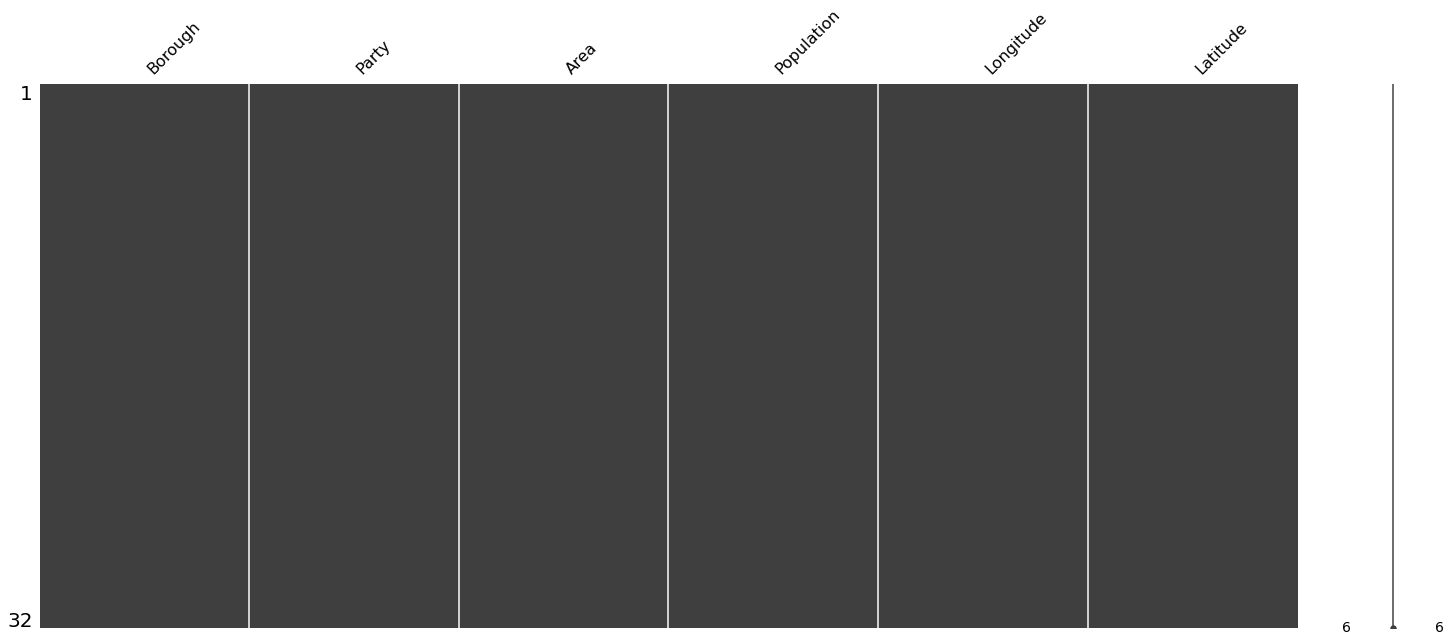

In [406]:
msno.matrix(df_london)

In [407]:
df_london['Party'].unique()

array(['Labour', 'Conservative', 'Conservative (council NOC)',
       'Liberal\xa0Democrat'], dtype=object)

In [408]:
df_london['Party'] = df_london['Party'].str.replace(' \(council NOC\)', '')

In [409]:
df_london['Party'] = df_london['Party'].str.replace('Liberal\xa0Democrat', 'Liberal Democrat')
df_london['Party'].unique()

array(['Labour', 'Conservative', 'Liberal Democrat'], dtype=object)

Text(0.5, 1.0, 'Political Control of London Boroughs')

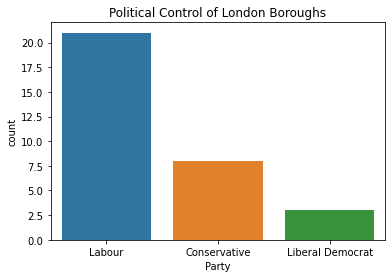

In [410]:
sns.countplot(x='Party', data=df_london)
plt.title('Political Control of London Boroughs')

In [411]:
df_london = df_london.sort_values(by=['Population'])
df_london.head()

,Borough,Party,Area,Population,Longitude,Latitude
18,Kensington and Chelsea,Conservative,4.68,156129,-0.1947,51.5020
19,Kingston upon Thames,Liberal Democrat,14.38,177507,-0.3064,51.4085
11,Hammersmith and Fulham,Labour,6.33,185143,-0.2339,51.4927
25,Richmond upon Thames,Liberal Democrat,22.17,198019,-0.3260,51.4479
27,Sutton,Liberal Democrat,16.93,206349,-0.1945,51.3618


Text(0.5, 1.0, 'Population of London Boroughs')

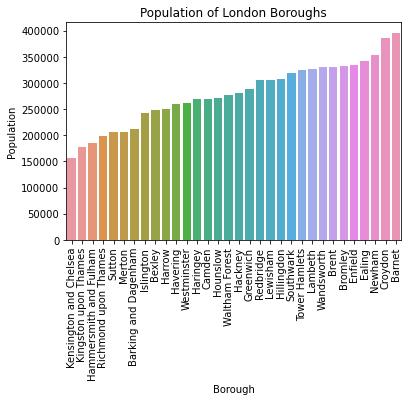

In [412]:
sns.barplot(x = df_london.Borough, y = df_london.Population)
plt.xticks(rotation=90)
plt.title('Population of London Boroughs')

City of London was not included in the original table, so the information was added manually:

In [413]:
df_london = df_london.append({'Borough':'City of London','Party':'None', 'Area':1.12, 'Population':9721, 'Longitude':-0.0922, 'Latitude':51.5155}, ignore_index=True)

Now we will visualize the Boroughs using folium. First the location of London will be gathered using Nominatim, this will then be used within folium to set the location for our zoomed in world map.

In [414]:
address = 'london'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [415]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

In [416]:
df_london['Borough'].unique()

array(['Kensington and Chelsea', 'Kingston upon Thames',
       'Hammersmith and Fulham', 'Richmond upon Thames', 'Sutton',
       'Merton', 'Barking and Dagenham', 'Islington', 'Bexley', 'Harrow',
       'Havering', 'Westminster', 'Haringey', 'Camden', 'Hounslow',
       'Waltham Forest', 'Hackney', 'Greenwich', 'Redbridge', 'Lewisham',
       'Hillingdon', 'Southwark', 'Tower Hamlets', 'Lambeth',
       'Wandsworth', 'Brent', 'Bromley', 'Enfield', 'Ealing', 'Newham',
       'Croydon', 'Barnet', 'City of London'], dtype=object)

In [417]:
# add markers to map
for lat, lng, label in zip(df_london['Latitude'], df_london['Longitude'], df_london['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  

In [418]:
map_london

Now let's set the index to the borough names, for ease of use when we import the other data.

In [419]:
df_london.reset_index(inplace=True)

In [420]:
df_london = df_london.set_index('Borough')

In [421]:
df_london.drop(columns=['index'], inplace=True)

In [422]:
df_london.head()

,Party,Area,Population,Longitude,Latitude
Borough,,,,,
Kensington and Chelsea,Conservative,4.68,156129,-0.1947,51.5020
Kingston upon Thames,Liberal Democrat,14.38,177507,-0.3064,51.4085
Hammersmith and Fulham,Labour,6.33,185143,-0.2339,51.4927
Richmond upon Thames,Liberal Democrat,22.17,198019,-0.3260,51.4479
Sutton,Liberal Democrat,16.93,206349,-0.1945,51.3618


### Demographic Data:
Now we'll grab the demographic data for each borough, clean it and add it to the DataFrame df_london.

In [423]:
url_londonDemo = 'https://en.wikipedia.org/wiki/Demography_of_London'
table_id = "wikitable sortable"

response = requests.get(url_londonDemo)
soup = BeautifulSoup(response.text, 'html.parser')

Demo_soup = soup.findAll('table',{ "class" : table_id})
df = pd.read_html(str(Demo_soup))
df_demographic = df[0]
df_demographic.head()

,Local authority,White,Mixed,Asian,Black,Other
0,Barnet,64.1,4.8,18.5,7.7,4.8
1,Barking and Dagenham,58.3,4.2,15.9,20.0,1.6
2,Bexley,81.9,2.3,6.6,8.5,0.8
3,Brent,36.3,5.1,34.1,18.8,5.8
4,Bromley,84.3,3.5,5.2,6.0,0.9


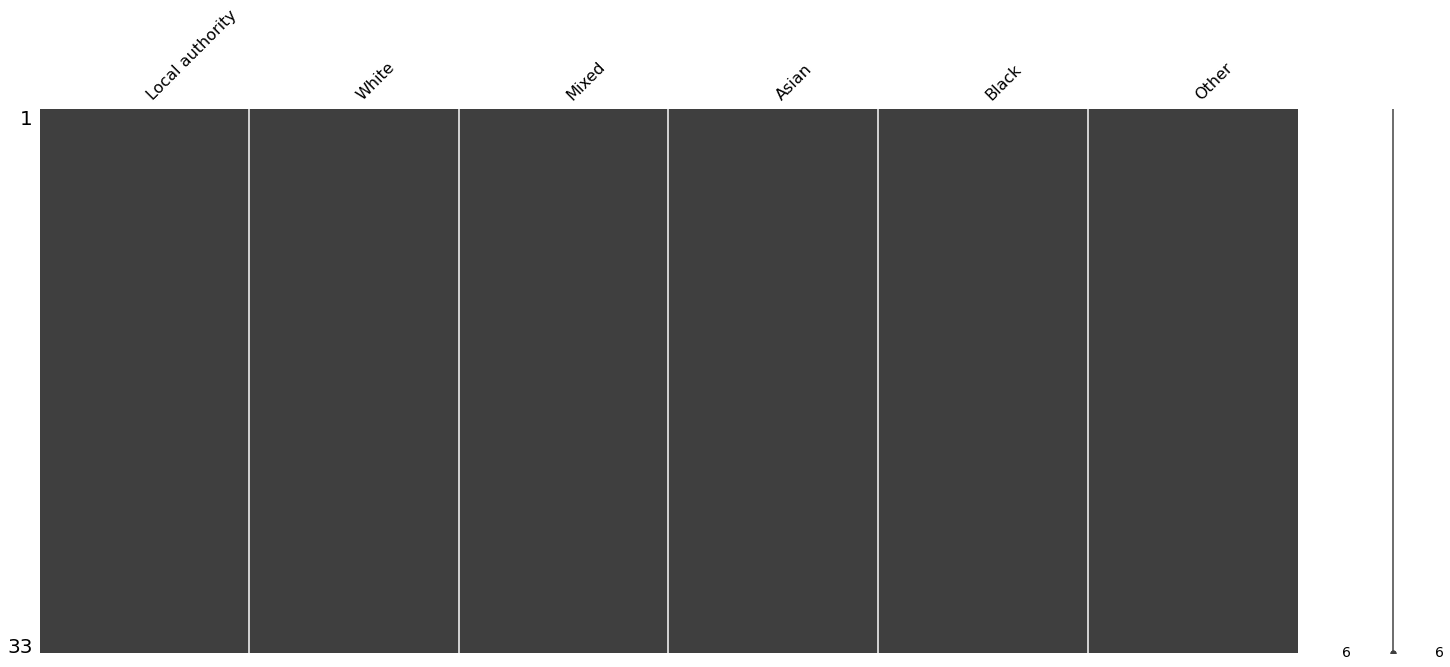

In [424]:
msno.matrix(df_demographic)

In [425]:
df_demographic.rename(columns={'Local authority' : 'Borough', 'Other' : 'Other Ethnicity'}, inplace=True)

In [426]:
df_demographic.set_index('Borough', inplace=True)
df_demographic.head()

,White,Mixed,Asian,Black,Other Ethnicity
Borough,,,,,
Barnet,64.1,4.8,18.5,7.7,4.8
Barking and Dagenham,58.3,4.2,15.9,20.0,1.6
Bexley,81.9,2.3,6.6,8.5,0.8
Brent,36.3,5.1,34.1,18.8,5.8
Bromley,84.3,3.5,5.2,6.0,0.9


In [427]:
df_london = pd.concat([df_london, df_demographic], axis=1)
df_london.head()

,Party,Area,Population,Longitude,Latitude,White,Mixed,Asian,Black,Other Ethnicity
Kensington and Chelsea,Conservative,4.68,156129,-0.1947,51.5020,70.6,5.7,10.0,6.5,7.2
Kingston upon Thames,Liberal Democrat,14.38,177507,-0.3064,51.4085,74.5,3.9,16.3,2.5,2.7
Hammersmith and Fulham,Labour,6.33,185143,-0.2339,51.4927,68.1,5.5,9.1,11.8,5.5
Richmond upon Thames,Liberal Democrat,22.17,198019,-0.3260,51.4479,86.0,3.6,7.3,1.5,1.6
Sutton,Liberal Democrat,16.93,206349,-0.1945,51.3618,78.6,3.8,11.6,4.8,1.3


### Salary Data:
We'll grab the median salary data and add it to the DataFrame df_london.

In [428]:
df_income = pd.read_excel('C:/Users/Damien/Desktop/IBM/Capstone Project/Data/earnings-residence-borough.xlsx', sheet_name='Total, weekly')
df_income.dropna(inplace=True)
df_income = df_income[['Area', 2020]]
df_income.rename(columns={2020: 'Weekly Income', 'Area' : 'Borough'}, inplace=True)
df_income.set_index('Borough', inplace=True)

In [429]:
df_london = pd.concat([df_london, df_income], axis=1)
df_london.tail()

,Party,Area,Population,Longitude,Latitude,White,Mixed,Asian,Black,Other Ethnicity,Weekly Income
Wales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,447.8
Scotland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,486.7
Northern Ireland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,432.3
England and Wales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,479.8
United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,479.1


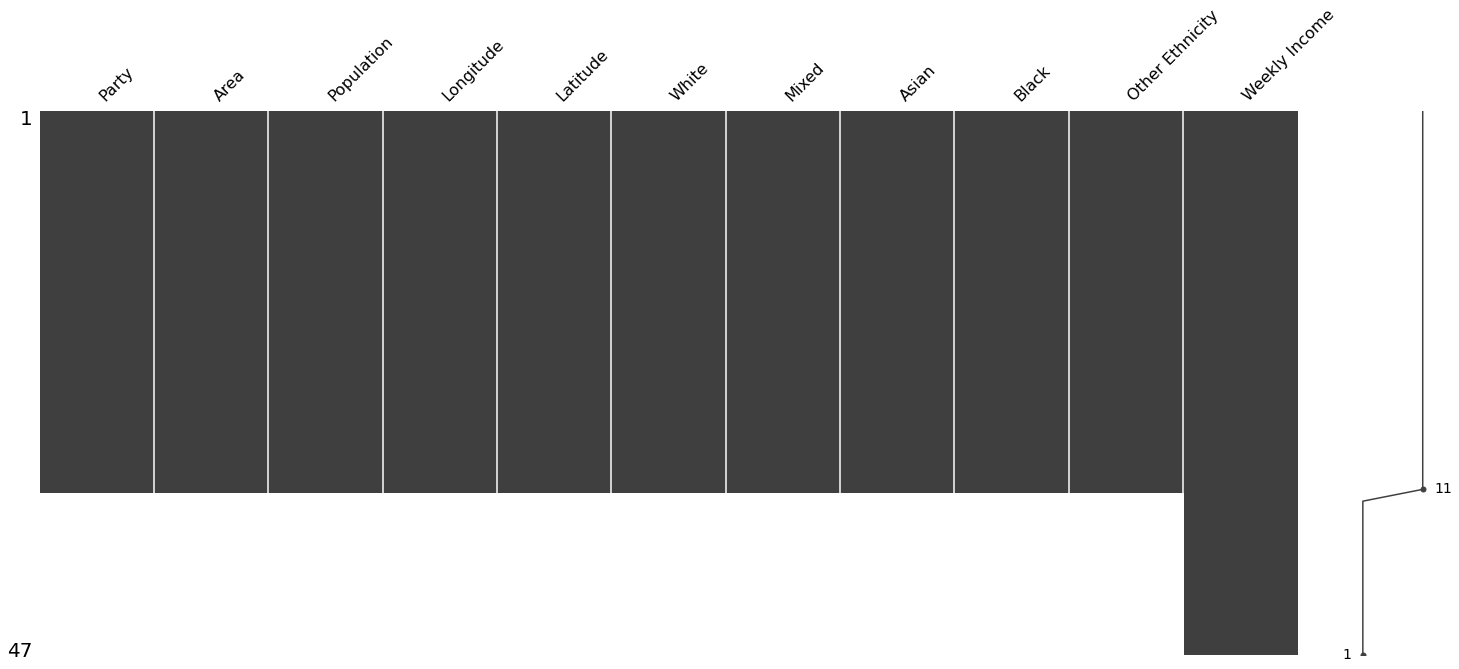

In [430]:
msno.matrix(df_london)

We can see this data included data on individual countries in the UK, so we will drop those rows, and check that we still have our remaining 33 boroughs.

DataFrame shape: (33, 11)


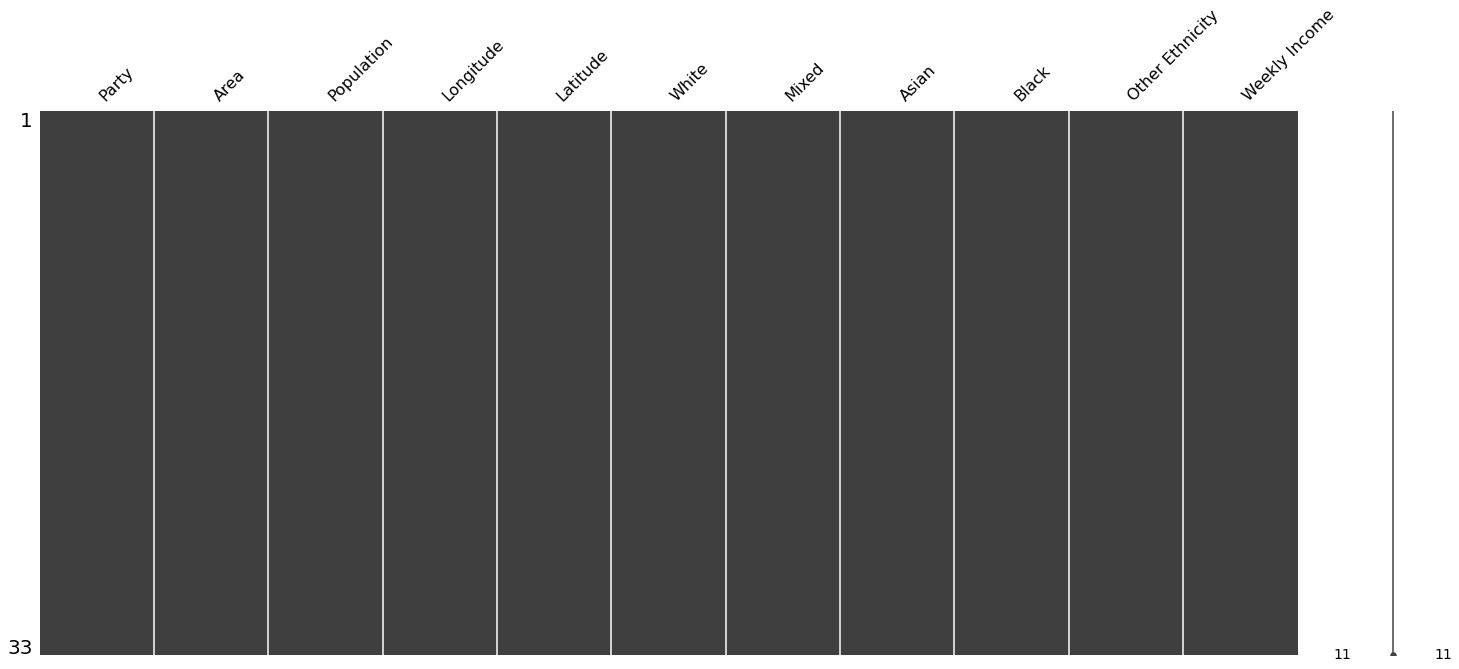

In [431]:
df_london.dropna(inplace=True)
print('DataFrame shape: ' + str(df_london.shape))
msno.matrix(df_london)

The median salary was missing so this was filled in manually with most recent data available online:

In [432]:
df_london['Weekly Income']['City of London'] = 971.5

<ipython-input-432-7b69db078b63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london['Weekly Income']['City of London'] = 971.5


In [433]:
df_london

,Party,Area,Population,Longitude,Latitude,White,Mixed,Asian,Black,Other Ethnicity,Weekly Income
Kensington and Chelsea,Conservative,4.68,156129.0,-0.1947,51.5020,70.6,5.7,10.0,6.5,7.2,784.3
Kingston upon Thames,Liberal Democrat,14.38,177507.0,-0.3064,51.4085,74.5,3.9,16.3,2.5,2.7,616.9
Hammersmith and Fulham,Labour,6.33,185143.0,-0.2339,51.4927,68.1,5.5,9.1,11.8,5.5,710.7
Richmond upon Thames,Liberal Democrat,22.17,198019.0,-0.3260,51.4479,86.0,3.6,7.3,1.5,1.6,702.5
Sutton,Liberal Democrat,16.93,206349.0,-0.1945,51.3618,78.6,3.8,11.6,4.8,1.3,543.3
Merton,Labour,14.52,206548.0,-0.1958,51.4014,64.9,4.7,18.1,10.4,1.9,577.9
Barking and Dagenham,Labour,13.93,212906.0,0.1557,51.5607,58.3,4.2,15.9,20.0,1.6,500.4
Islington,Labour,5.74,242467.0,-0.1022,51.5416,68.2,6.5,9.2,12.8,3.4,704.2
Bexley,Conservative,23.38,248287.0,0.1505,51.4549,81.9,2.3,6.6,8.5,0.8,568.3
Harrow,Labour,19.49,251160.0,-0.3346,51.5898,42.2,4.0,42.6,8.2,2.9,566.7


### Age Data:
The data will be pulled from online, cleaned, and then 4 age groups will be defined as follows:
- Children (Age: 0-18)
- Young Adults (Age: 19-39)
- Adult (Age: 40-59)
- Older Adults (Age: 60+)

Finally the data will be added to the DataFrame df_london.

In [434]:
df_age = pd.read_excel('C:/Users/Damien/Desktop/IBM/Capstone Project/Data/population-estimates-single-year-age.xls', sheet_name='2015')
df_age.dropna(inplace=True)

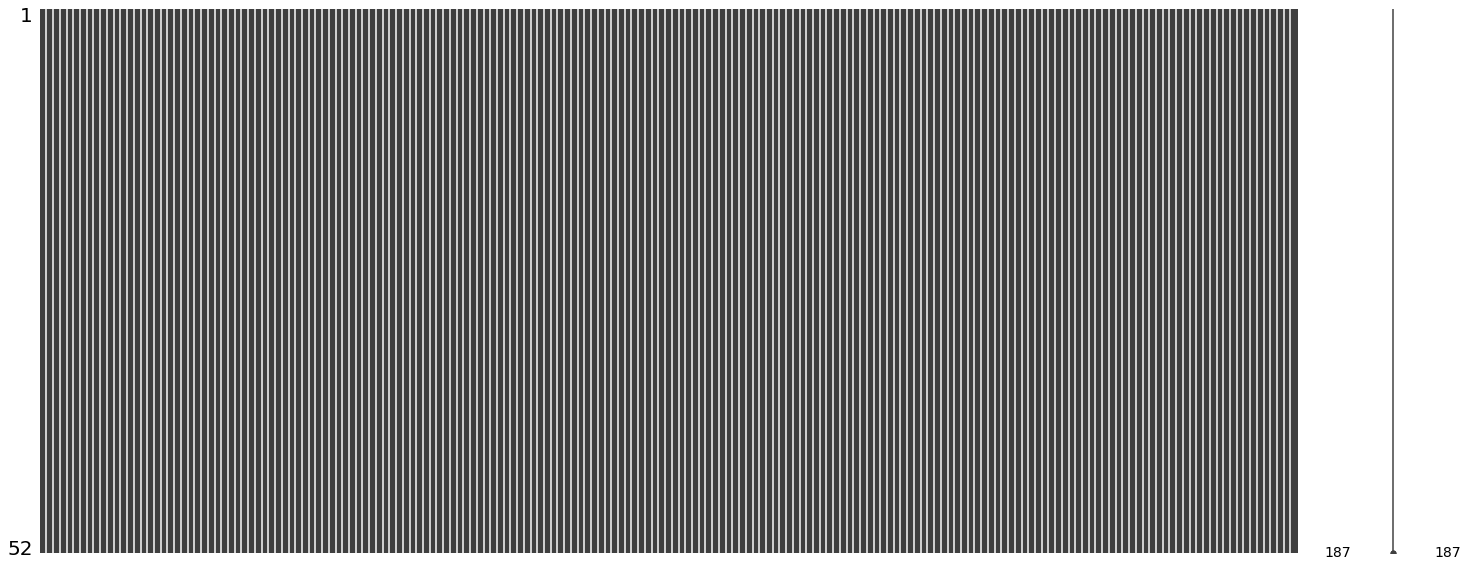

In [435]:
msno.matrix(df_age)

In [436]:
df_age.shape

(52, 187)

In [437]:
df_age.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'PERSONS', '   MALES', '   MALES.1',
       '   MALES.2', '   MALES.3', '   MALES.4', '   MALES.5', '   MALES.6',
       ...
       ' FEMALES.82', ' FEMALES.83', ' FEMALES.84', ' FEMALES.85',
       ' FEMALES.86', ' FEMALES.87', ' FEMALES.88', ' FEMALES.89',
       ' FEMALES.90', ' FEMALES.91'],
      dtype='object', length=187)

In [438]:
age_young = list(range(1,20))
age_YoungAdult = list(range(20, 41))
age_Adult = list(range(41, 61))
age_OlderAdult = list(range(61,91))

In [439]:
youngM = ['   MALES.' + str(x) for x in age_young]
youngF = [' FEMALES.' + str(x) for x in age_young]

youngYoungAdultM = ['   MALES.' + str(x) for x in age_YoungAdult]
youngYoungAdultF=  [' FEMALES.' + str(x) for x in age_YoungAdult]

youngAdultM = ['   MALES.' + str(x) for x in age_Adult]
youngAdultF=  [' FEMALES.' + str(x) for x in age_Adult]

youngOlderAdultM = ['   MALES.' + str(x) for x in age_OlderAdult]
youngOlderAdultF=  [' FEMALES.' + str(x) for x in age_OlderAdult]



In [440]:
Young = youngM + youngF
YAdult = youngYoungAdultM + youngYoungAdultF
Adult = youngAdultM + youngAdultF
OAdult = youngOlderAdultM + youngOlderAdultF

In [441]:
Young = ['Unnamed: 1'] + Young
YAdult = ['Unnamed: 1'] + YAdult
Adult = ['Unnamed: 1'] + Adult
OAdult = ['Unnamed: 1'] + OAdult

In [442]:
df_child = df_age[Young]
df_YAdult = df_age[YAdult]
df_Adult = df_age[Adult]
df_OAdult = df_age[OAdult]

In [443]:
ageData = dict()
ageData['Child'] = df_child
ageData['Young Adult'] = df_YAdult
ageData['Adult'] = df_Adult
ageData['Older Adult'] = df_OAdult

In [444]:
for i in ageData.keys():
    ageData[i]['Total'] = ageData[i].sum(axis=1)
    ageData[i] = ageData[i][['Unnamed: 1', 'Total']]
    ageData[i].rename(columns={'Unnamed: 1' : 'Borough', 'Total' : 'Total ' + str(i) + ' Population'}, inplace=True)

<ipython-input-444-ae9b2f3e17be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ageData[i]['Total'] = ageData[i].sum(axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [445]:
for i in ageData.keys():
    ageData[i].set_index('Borough', inplace=True)

In [446]:
ageData['Young Adult'].head()

,Total Young Adult Population
Borough,
Area,1218.0
City of London,3262.0
Barking and Dagenham,63320.0
Barnet,119414.0
Bexley,65861.0


In [447]:
for i in ageData.keys():
    df_london = pd.concat([df_london, ageData[i]], axis=1)

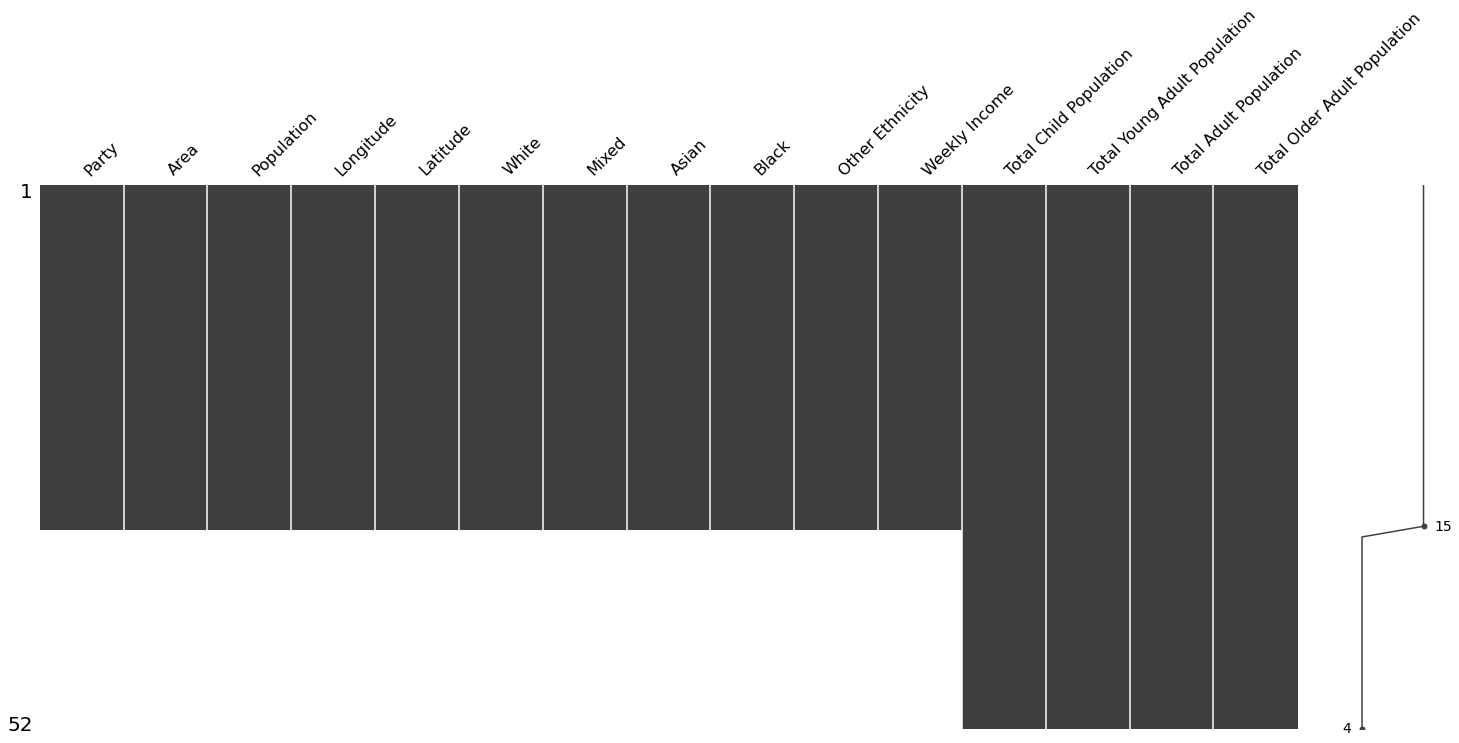

In [448]:
msno.matrix(df_london)

In [449]:
df_london.dropna(inplace=True)

In [450]:
df_london['Pop Density'] = round(df_london['Population'] / df_london['Area'],2)

In [451]:
df_london['Salary'] = df_london['Weekly Income'] * 52

In [452]:
df_london['Total Population'] = df_london['Total Child Population'] + df_london['Total Young Adult Population'] + df_london['Total Adult Population'] + df_london['Total Older Adult Population']

In [453]:
df_london['Children'] = round((df_london['Total Child Population'] / df_london['Total Population'])*100,2)
df_london['Young Adult'] = round((df_london['Total Young Adult Population'] / df_london['Total Population'])*100,2)
df_london['Adult'] = round((df_london['Total Adult Population'] / df_london['Total Population'])*100,2)
df_london['Older Adult'] = round((df_london['Total Older Adult Population'] / df_london['Total Population'])*100,2)

### Religious Data:
The religious data was pulled from the website and downloaded as a csv. Once that was read into pandas, the data was cleaned and added to the DataFrame df_london.

In [454]:
df_religion = pd.read_excel('C:/Users/Damien/Desktop/IBM/Capstone Project/Data/population-by-religion-borough.xls', sheet_name='2018', header=1)

In [455]:
df_religion = df_religion[['Area name', 'Christian.2', 'Buddhist.2', 'Hindu.2', 'Jewish.2', 'Muslim.2', 'Sikh.2', 'Any Other Religion.2','No Religion.2']]

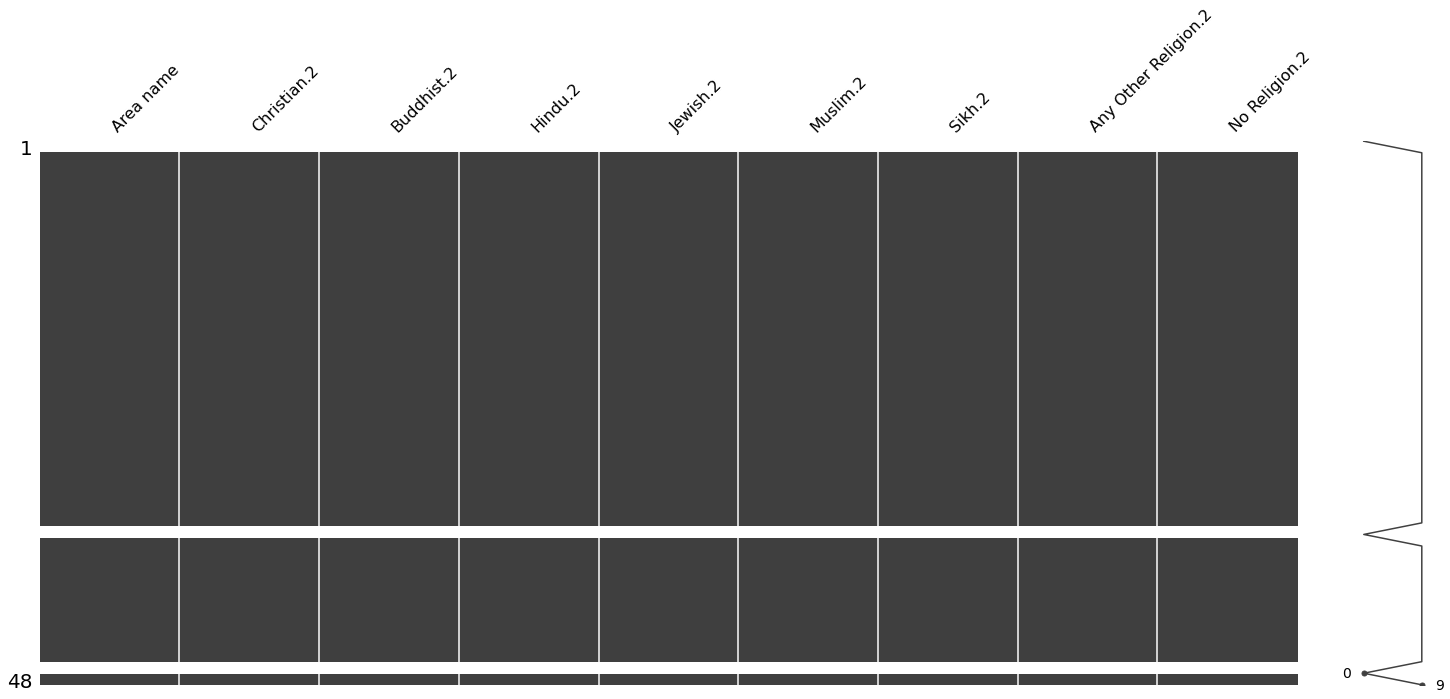

In [456]:
msno.matrix(df_religion)

In [457]:
df_religion.dropna(inplace=True)

In [458]:
df_religion.head()

,Area name,Christian.2,Buddhist.2,Hindu.2,Jewish.2,Muslim.2,Sikh.2,Any Other Religion.2,No Religion.2
1,City of London,-,-,-,-,-,-,-,-
2,Barking and Dagenham,53.9,-,3,-,25.3,1.5,-,15.5
3,Barnet,39.2,1.9,4,19.2,11.8,-,4.4,19.4
4,Bexley,59.5,-,1.8,-,4.7,-,2.2,31.8
5,Brent,33.9,-,15.7,-,29.7,-,5.6,15


In [459]:
df_religion.replace('-','0', inplace=True)

In [460]:
df_religion.rename(columns={'Area name':'Borough', 'Christian.2':'Christian', 'Buddhist.2':'Buddhist', 'Hindu.2':'Hindu','Jewish.2':'Jewish', 'Muslim.2':'Muslim', 'Sikh.2': 'Sikh', 'Any Other Religion.2' :'Other Religion', 'No Religion.2':'No Religion'}, inplace = True)

In [461]:
df_religion.set_index('Borough', inplace=True)

In [462]:
df_religion.head()

,Christian,Buddhist,Hindu,Jewish,Muslim,Sikh,Other Religion,No Religion
Borough,,,,,,,,
City of London,0,0,0,0,0,0,0,0
Barking and Dagenham,53.9,0,3,0,25.3,1.5,0,15.5
Barnet,39.2,1.9,4,19.2,11.8,0,4.4,19.4
Bexley,59.5,0,1.8,0,4.7,0,2.2,31.8
Brent,33.9,0,15.7,0,29.7,0,5.6,15


In [463]:
df_london = pd.concat([df_london, df_religion], axis=1)

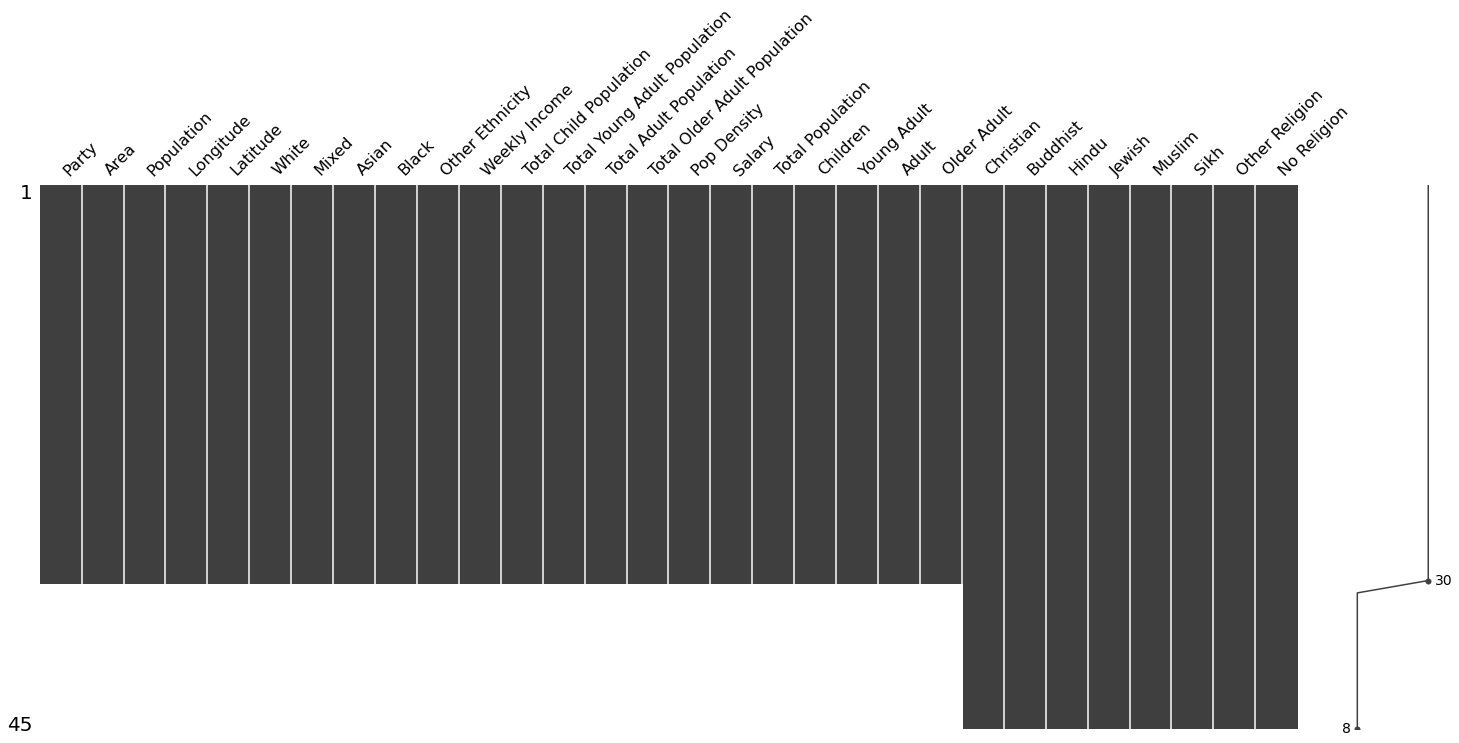

In [464]:
msno.matrix(df_london)

In [465]:
df_london.dropna(inplace=True)

In [466]:
df_london.columns

Index(['Party', 'Area', 'Population', 'Longitude', 'Latitude', 'White',
       'Mixed', 'Asian', 'Black', 'Other Ethnicity', 'Weekly Income',
       'Total Child Population', 'Total Young Adult Population',
       'Total Adult Population', 'Total Older Adult Population', 'Pop Density',
       'Salary', 'Total Population', 'Children', 'Young Adult', 'Adult',
       'Older Adult', 'Christian', 'Buddhist', 'Hindu', 'Jewish', 'Muslim',
       'Sikh', 'Other Religion', 'No Religion'],
      dtype='object')

Now let's clean up some of the useless columns, and then create some features we want to use like annual salary (instead of weekly), and make sure we convert all our data to the proper format.

In [467]:
df_london.drop(columns=['Area', 'Population', 'Total Child Population', 'Total Young Adult Population', 'Total Adult Population', 'Total Older Adult Population', 'Weekly Income'], inplace=True)
df_london.head()

,Party,Longitude,Latitude,White,Mixed,Asian,Black,Other Ethnicity,Pop Density,Salary,...,Adult,Older Adult,Christian,Buddhist,Hindu,Jewish,Muslim,Sikh,Other Religion,No Religion
Kensington and Chelsea,Conservative,-0.1947,51.5020,70.6,5.7,10.0,6.5,7.2,33360.90,40783.6,...,27.45,18.47,48.9,1.7,1.7,4.7,10.3,0,6,26.8
Kingston upon Thames,Liberal Democrat,-0.3064,51.4085,74.5,3.9,16.3,2.5,2.7,12344.02,32078.8,...,26.30,16.90,41.9,1.3,6.1,0,11,0,2.2,37.6
Hammersmith and Fulham,Labour,-0.2339,51.4927,68.1,5.5,9.1,11.8,5.5,29248.50,36956.4,...,25.22,13.59,52.9,2.3,0,0,10.8,0,4,29.9
Richmond upon Thames,Liberal Democrat,-0.3260,51.4479,86.0,3.6,7.3,1.5,1.6,8931.84,36530,...,29.86,18.90,51.3,0,0,2.1,3.6,0,7.3,35.8
Sutton,Liberal Democrat,-0.1945,51.3618,78.6,3.8,11.6,4.8,1.3,12188.36,28251.6,...,28.51,19.08,48.8,0,8.2,0,7.3,0,2.1,33.6


In [468]:
df_london['Salary'] = df_london['Salary'].astype('float')
df_london['Christian'] = df_london['Christian'].astype('float')
df_london['Buddhist'] = df_london['Buddhist'].astype('float')
df_london['Hindu'] = df_london['Hindu'].astype('float')
df_london['Jewish'] = df_london['Jewish'].astype('float')
df_london['Muslim'] = df_london['Muslim'].astype('float')
df_london['Sikh'] = df_london['Sikh'].astype('float')
df_london['Other Religion'] = df_london['Other Religion'].astype('float')
df_london['No Religion'] = df_london['No Religion'].astype('float')

In [469]:
df_london['Political Categorical'] = df_london['Party'].astype('category').cat.codes

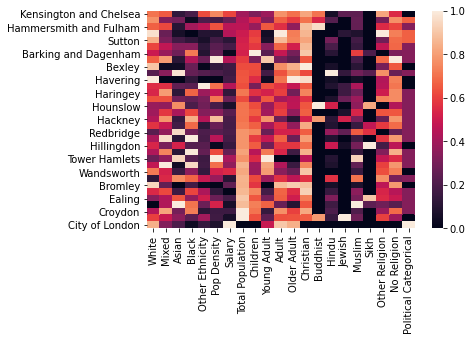

In [470]:
london_data = df_london.drop(columns=['Party', 'Longitude', 'Latitude'])
def scaleColumns(df):
    for i in list(df.columns):
        x_std = (df[i] - df[i].min())/(df[i].max() - df[i].min())
        df[i] = x_std * (1 - 0) + 0
    return df

london_data = scaleColumns(london_data)
ax = sns.heatmap(london_data)

## Model Building: K-Means Clustering:
Now we will use K-means clustering on the data to identify similar boroughs across London. We will use 5 clusters for this data. We will also normalize a few of the features so they don't over influence our clusters.

In [471]:
kclusters = 5
kmeans_london = KMeans(n_clusters=kclusters, random_state=0).fit(london_data)

In [472]:
df_london['Cluster Labels'] = kmeans_london.labels_

We assigned the cluster values back to the DataFrame, and now we can visualize the clusters using Folium.

In [473]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_london['Latitude'], df_london['Longitude'], df_london.index, df_london['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Foursquare Data:
Using our Latitiude and Longitude for each borrow, we will query the FourSquare Database to collect venue information for each borough.

In [474]:
CLIENT_ID = 'WCZMV0FKCAJFRUUNZ1URWVEREMYVV20PI033XM0FC4XHAPWF'
CLIENT_SECRET = 'TJ1FEOSXPLN5GABGVOR3UO5W224VCEEYIRMDNDBXPNMLERH2'
VERSION = '20180605'
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [153]:
london_venues = getNearbyVenues(names=df_london.index,
                                   latitudes=df_london['Latitude'],
                                   longitudes=df_london['Longitude']
                                  )

Kensington and Chelsea
Kingston upon Thames
Hammersmith and Fulham
Richmond upon Thames
Sutton
Merton
Barking and Dagenham
Islington
Bexley
Harrow
Havering
Westminster
Haringey
Camden
Hounslow
Waltham Forest
Hackney
Greenwich
Redbridge
Lewisham
Hillingdon
Southwark
Tower Hamlets
Lambeth
Wandsworth
Brent
Bromley
Enfield
Ealing
Newham
Croydon
Barnet
City of London


In [475]:
# The data was saved and stored so that the 
# FourSquare API would not have to be queried multiple times

# london_venues = pd.read_csv('C:/Users/Damien/Desktop/IBM/Capstone Project/Data/London_venues.csv')

In [476]:
london_venues.shape

(2292, 8)

In [477]:
print('There are {} uniques categories and {} different venues in London.'.format(len(london_venues['Venue Category'].unique()), london_venues.shape[0]))

There are 266 uniques categories and 2292 different venues in London.


### Reducing the category space
Since we don't want to have such specific categories when approaching our developer, we grouped various venues into similar categories (e.g. Thai Restaurant and Japanese Restaurant became a category of Asian Restaurants).
The dictionary below helped this process.

In [478]:
categorize_dic = {
'Indian Restaurant': 'Asian Restaurant',
'English Restaurant': 'European Restaurant',
'Sushi Restaurant': 'Asian Restaurant',
'Gym' : 'Fitness',
'Gym / Fitness Center': 'Fitness',
'Japanese Restaurant': 'Asian Restaurant',
'French Restaurant': 'European Restaurant',
'Italian Restaurant': 'European Restaurant',
'History Museum': 'Museum',
'Mediterranean Restaurant' : 'European Restaurant',
'Sporting Goods Shop': 'Specialty Store',
'Clothing Store': 'Specialty Store',
'Modern European Restaurant' : 'European Restaurant',
'Breakfast Spot' : 'Restaurant',
'Chinese Restaurant' : 'Asian Restuarant',
'Yoga Studio' : 'Fitness',
'Greek Restaurant' : 'European Restaurant',
'Pilates Studio' : 'Fitness',
'Persian Restaurant' : 'Middle Eastern Restaurant',
'Art Gallery':'Exhibit',
'Café' : 'Coffee Shop',
'Thai Restaurant' : 'Asian Restaurant',
'Sandwich Place': 'Take away',
'Gastropub':'Pub',
'Supermarket':'Grocery Store',
'Filipino Restaurant':'Asian Restaurant',
'Outdoor Sculpture':'Exhibit',
'Portuguese Restaurant':'European Restaurant',
'Farmers Market':'Market',
'German Restaurant':'European Restaurant',
'Cajun / Creole Restaurant': 'North American Restaurant',
'Turkish Restaurant':'Middle Eastern Restaurant',
'Beer Bar':'Pub',
'Mexican Restaurant':'Latin American Restaurant',
'Rock Club':'Club',
'Bar':'Pub',
'Arts & Crafts Store':'Specialty Store',
'Bookstore':'Specialty Store',
'Public Art':'Exhibit',
'Chocolate Shop':'Specialty Store',
'Burrito Place':'Latin American Restaurant',
'Fish & Chips Shop':'European Restaurant',
'Stationery Store':'Specialty Store',
'Candy Store':'Specialty Store',
'Souvlaki Shop':'Specialty Store',    
'Kitchen Supply Store':'Specialty Store',
"Women's Store":'Specialty Store',  
'Falafel Restaurant':'Middle Eastern Restaurant',
'Smoothie Shop':'Drink Take away',
'Juice Bar':'Drink Take away',
'Vegetarian / Vegan Restaurant':'Restaurant',
'Polish Restaurant':'European Restaurant',
'Tapas Restaurant':'European Restaurant', 
'Bubble Tea Shop':'Drink Take away',
'Jazz Club':'Club',
'Vietnamese Restaurant':'Asian Restaurant',
'Cocktail Bar' : 'Pub', 
'Furniture / Home Store' : 'Specialty Store', 
'Fish Market' : 'Market',
'Fast Food Restaurant' : 'Take away',
'Deli / Bodega' : 'Take away', 
'Beer Garden' : 'Pub',
'BBQ Joint' : 'North American Restaurant', 
'Steakhouse': 'North American Restaurant',
'Athletics & Sports':'Specialty Store',
'Warehouse Store':'Department Store',
'Irish Pub':'Pub',
'Ice Cream Shop':'Dessert Shop',
'Boutique':'Specialty Store',
'Music Venue':'Club', 
'Kebab Restaurant':'Take away', 
'Organic Grocery' : 'Grocery Store', 
'Hobby Shop':'Specialty Store',
'Afghan Restaurant':'Middle Eastern Restaurant', 
'Spanish Restaurant':'European Restaurant',
'Cheese Shop':'Specialty Store',
'Hunan Restaurant':'Asian Restaurant', 
'Brewery':'Pub',
'Korean Restaurant':'Asian Restaurant',
'American Restaurant':'North American Restaurant',
"Men's Store":'Specialty Store',
'Poke Place': 'Restaurant',
'Cycle Studio':'Fitness', 
'Dumpling Restaurant':'Restaurant',
'Outlet Mall':'Shopping center',
'Light Rail Station':'Station',
'Indie Movie Theater':'Movie Theater', 
'Street Art':'Exhibit',
'Okonomiyaki Restaurant' :'Asian Restaurant',
'New American Restaurant':'North American Restaurant',
'South American Restaurant':'North American Restaurant',
'Dim Sum Restaurant':'Asian Restaurant',
'Champagne Bar':'Pub',
'Diner':'Restaurant',
'Cantonese Restaurant':'Asian Restaurant',
'Lebanese Restaurant':'Middle Eastern Restaurant',
'Bistro':'Take away',
'Outlet Store':'Department Store',
'Gelato Shop':'Dessert Shop',
'Bridal Shop':'Specialty Store',
'Shoe Store':'Specialty Store',
'Outdoor Supply Store':'Specialty Store',
'Noodle House':'Restaurant',
'Southern / Soul Food Restaurant':'North American Restaurant',
'Doner Restaurant':'Restaurant',
'Bagel Shop':'Bakery',
'Boxing Gym':'Fitness',
'Whisky Bar':'Pub',
'Bar':'Pub',
'Seafood Restaurant':'Restaurant',
'Bus Stop':'Station',
'Soccer Stadium':'Field',
'Train Station':'Station',
'Pet Store':'Specialty Store',
'Metro Station':'Station',
'Tram Station':'Station',
'Discount Store':'Specialty Store',
'Bus Station':'Station',
'Construction & Landscaping':'Specialty Store',
'Soccer Field':'Field',
'Sports Club':'Fitness',
'Nightclub':'Club',
'Platform':'Station',
'Multiplex':'Movie Theater',
'Brazilian Restaurant':'Latin American Restaurant',
'Music Store':'Specialty Store',
'Thrift / Vintage Store':'Specialty Store',
'Hotel Bar':'Pub',
'Salad Place':'Restaurant',
'Camera Store':'Specialty Store',
'Gourmet Shop':'Specialty Store',
'Performing Arts Venue':'Club',
'Food & Drink Shop':'Take away',
'Track Stadium':'Field',
'Food':'Restaurant',
'Stadium':'Field',
'Mobile Phone Shop':'Specialty Store',
'Malay Restaurant':'Asian Restaurant',
'Speakeasy':'Pub',
'Science Museum':'Museum',
'Shopping Plaza':'Shopping center',
'Theme Park Ride / Attraction':'Theme Park',
'Bed & Breakfast':'Hotel',
'Sports Bar':'Pub',
'Eastern European Restaurant':'European Restaurant',
'Gay Bar':'Pub',
'Jewelry Store':'Specialty Store',
'Beer Store':'Specialty Store',
'Convenience Store':'Grocery Store',
'Butcher':'Specialty Store',
'Ramen Restaurant':'Asian Restaurant',
'Flea Market':'Market',
'Taiwanese Restaurant':'Asian Restaurant',
'Sculpture Garden':'Exhibit',
'Buffet':'Restaurant',
'Fried Chicken Joint':'Take away',
'Hardware Store':'Specialty Store',
'Toy / Game Store':'Specialty Store',
'Food Stand':'Take away',
'Empanada Restaurant':'Restaurant',
'Bike Shop':'Specialty Store',
'Fruit & Vegetable Store':'Specialty Store',
'Badminton Court':'Field',
'Cupcake Shop':'Bakery',
'Record Shop':'Specialty Store',
'Monument / Landmark':'Historic Site',
'Shopping Mall':'Shopping center',
'Donut Shop':'Dessert shop',
'Video Game Store':'Specialty Store',
'Optical Shop':'Specialty Store',
'Cricket Ground':'Field',
}

In [479]:
london_venues.replace({'Venue Category':categorize_dic}, inplace=True)

In [480]:
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Borough'] = london_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

In [481]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
london_grouped.head()

,Borough,African Restaurant,Airport,Airport Lounge,Airport Service,Asian Restaurant,Asian Restuarant,Australian Restaurant,Austrian Restaurant,Auto Garage,...,Tea Room,Tennis Court,Theater,Theme Park,Trail,Tunnel,Windmill,Wine Bar,Wine Shop,Winery
0,Barking and Dagenham,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Barnet,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bexley,0.0,0.0,0.0,0.0,0.000000,0.041667,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Brent,0.0,0.0,0.0,0.0,0.043011,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bromley,0.0,0.0,0.0,0.0,0.079365,0.015873,0.0,0.0,0.0,...,0.0,0.0,0.015873,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [482]:
london_grouped.shape

(33, 110)

In [483]:
num_top_venues = 10
top_10 = dict()

for hood in london_grouped['Borough']:
    temp = london_grouped[london_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    temp['Area'] = hood
    top_10[hood] = temp

In [484]:
cluster_1 = list(df_london.loc[df_london['Cluster Labels'] == 0, df_london.columns[[1] + list(range(5, df_london.shape[1]))]].index)
cluster_2 = list(df_london.loc[df_london['Cluster Labels'] == 1, df_london.columns[[1] + list(range(5, df_london.shape[1]))]].index) 
cluster_3 = list(df_london.loc[df_london['Cluster Labels'] == 2, df_london.columns[[1] + list(range(5, df_london.shape[1]))]].index) 
cluster_4 = list(df_london.loc[df_london['Cluster Labels'] == 3, df_london.columns[[1] + list(range(5, df_london.shape[1]))]].index) 
cluster_5 = list(df_london.loc[df_london['Cluster Labels'] == 4, df_london.columns[[1] + list(range(5, df_london.shape[1]))]].index) 

In [485]:
def venuesCluster(cluster):
    dict_cluster = dict()
    for j in cluster:
        for i in list(top_10[j]['venue']):
            if i in dict_cluster:
                dict_cluster[i] += float(top_10[j][top_10[j]['venue'] == i]['freq'].values)
            else:
                dict_cluster[i] = float(top_10[j][top_10[j]['venue'] == i]['freq'].values)
    return dict_cluster

In [486]:
dict_cluster1 = venuesCluster(cluster_1)
dict_cluster2 = venuesCluster(cluster_2)
dict_cluster3 = venuesCluster(cluster_3)
dict_cluster4 = venuesCluster(cluster_4)
dict_cluster5 = venuesCluster(cluster_5)

In [487]:
import operator
dict_cluster1
sorted_cluster1 = sorted(dict_cluster1.items(), key=operator.itemgetter(1))
cluster1_top10 = sorted_cluster1[::-1][:10]

sorted_cluster2 = sorted(dict_cluster2.items(), key=operator.itemgetter(1))
cluster2_top10 = sorted_cluster2[::-1][:10]


sorted_cluster3 = sorted(dict_cluster3.items(), key=operator.itemgetter(1))
cluster3_top10 = sorted_cluster3[::-1][:10]


sorted_cluster4 = sorted(dict_cluster4.items(), key=operator.itemgetter(1))
cluster4_top10 = sorted_cluster4[::-1][:10]


sorted_cluster5 = sorted(dict_cluster5.items(), key=operator.itemgetter(1))
cluster5_top10 = sorted_cluster5[::-1][:10]

In [488]:
cluster1_top10 = pd.DataFrame(cluster1_top10, columns=['venue', 'freq'])
cluster2_top10 = pd.DataFrame(cluster2_top10, columns=['venue', 'freq'])
cluster3_top10 = pd.DataFrame(cluster3_top10, columns=['venue', 'freq'])
cluster4_top10 = pd.DataFrame(cluster4_top10, columns=['venue', 'freq'])
cluster5_top10 = pd.DataFrame(cluster5_top10, columns=['venue', 'freq'])

In [489]:
def compare_graph(df_cluster, borough, cluster_num):
    fig, axes = plt.subplots(1,2)
    sns.barplot(x='venue', y = 'freq', data = df_cluster, ax=axes[0])
    plt.sca(axes[0])
    plt.title('Cluster ' + str(cluster_num))
    plt.xticks(rotation=90)
    sns.barplot(x='venue', y = 'freq', data = top_10[str(borough)], ax=axes[1])
    plt.sca(axes[1])
    plt.title(str(borough))
    plt.xticks(rotation=90)
    return plt.show()

### Results:

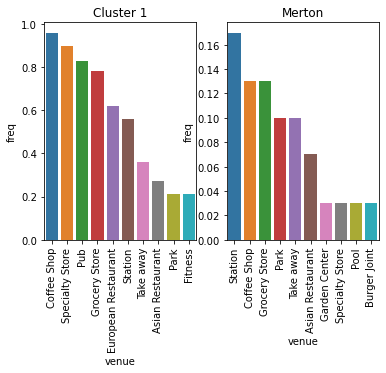

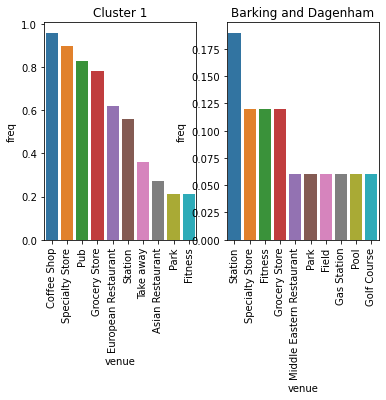

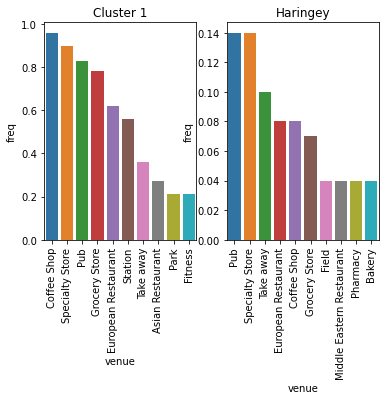

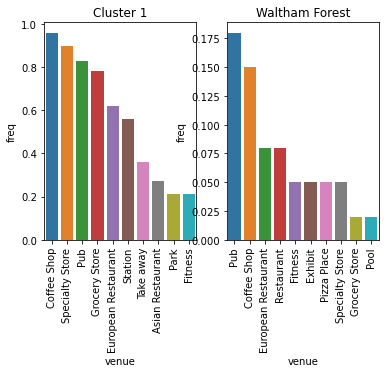

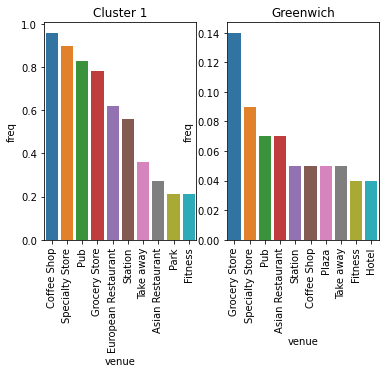

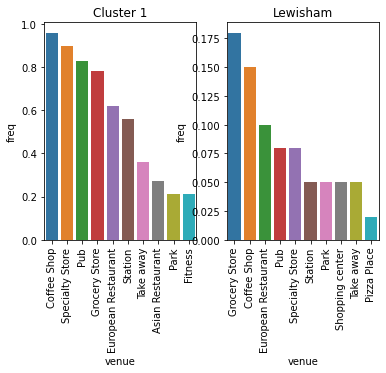

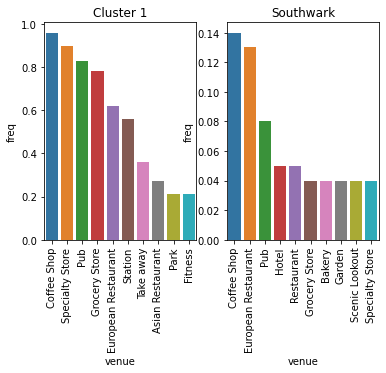

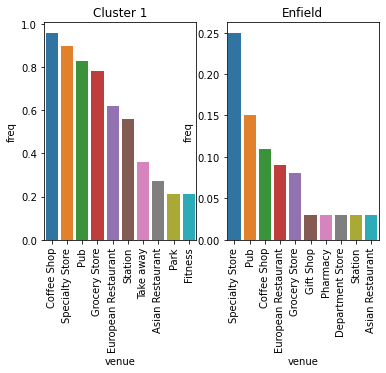

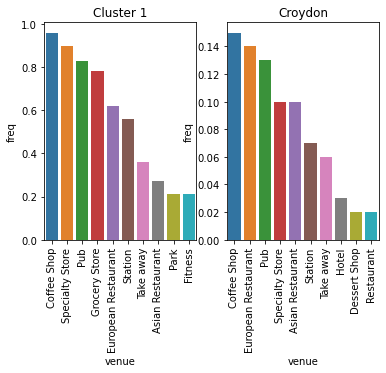

In [490]:
for i in cluster_1:
    compare_graph(cluster1_top10, i, 1)

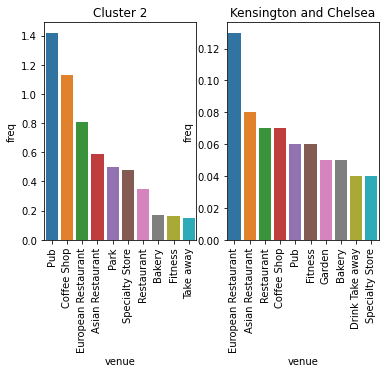

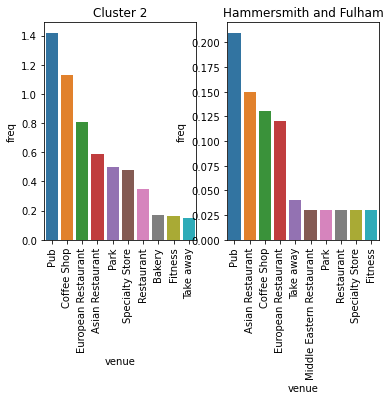

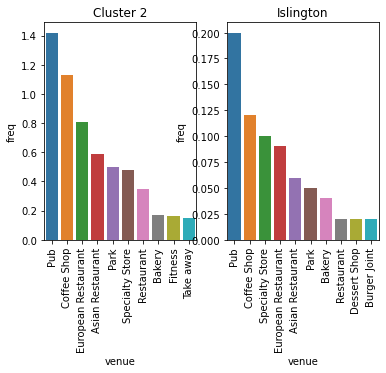

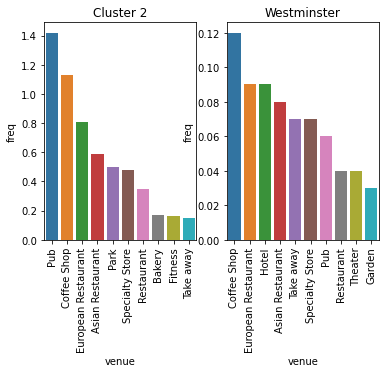

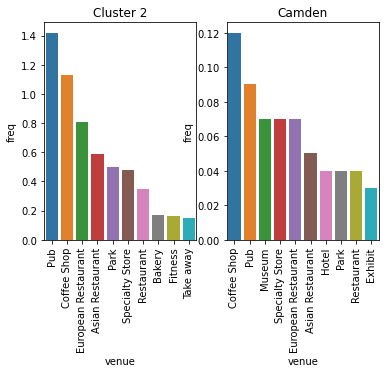

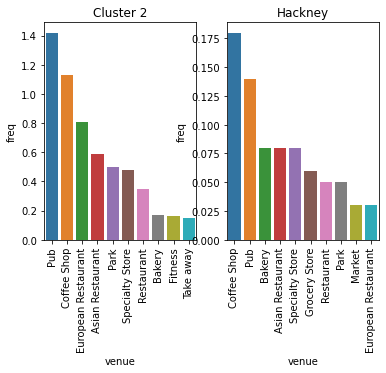

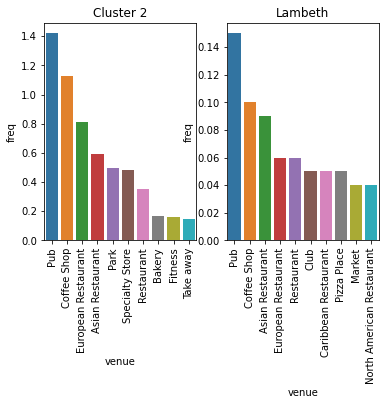

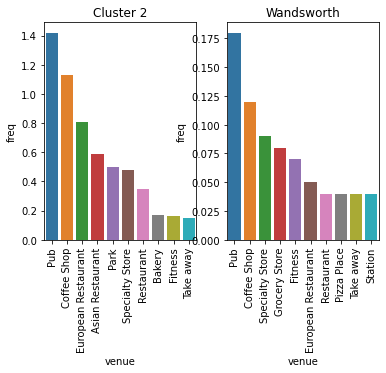

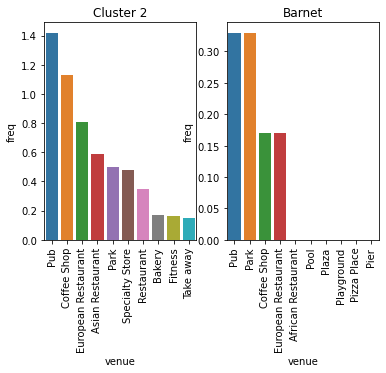

In [491]:
for i in cluster_2:
    compare_graph(cluster2_top10, i, 2)

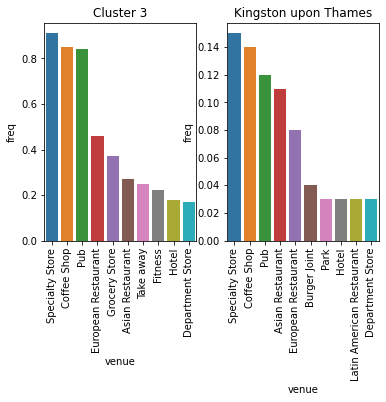

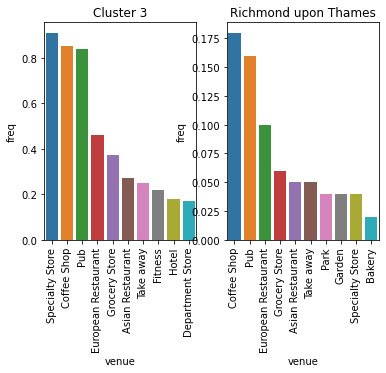

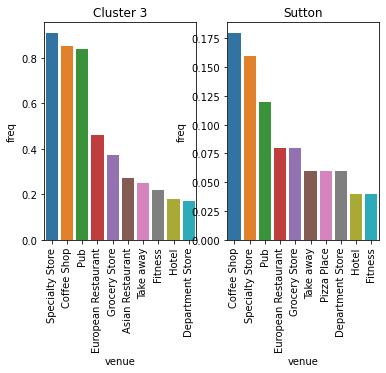

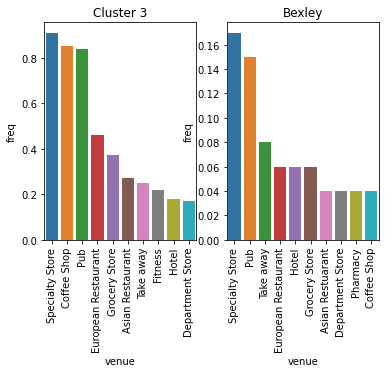

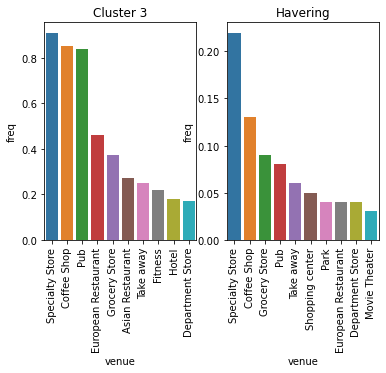

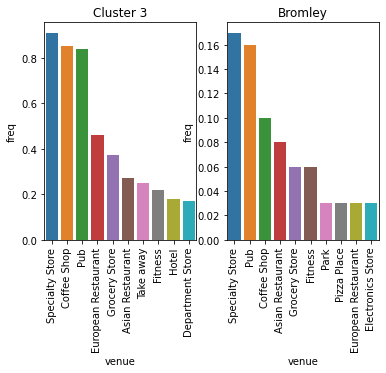

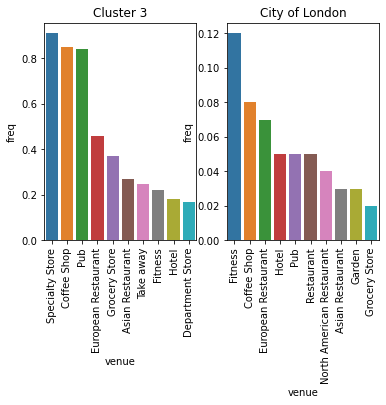

In [492]:
for i in cluster_3:
    compare_graph(cluster3_top10, i, 3)

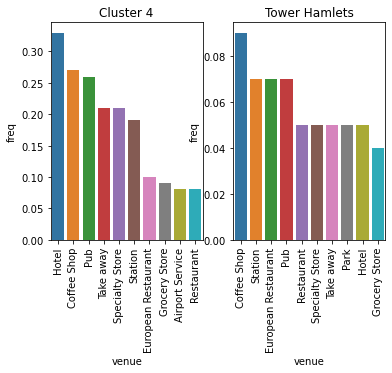

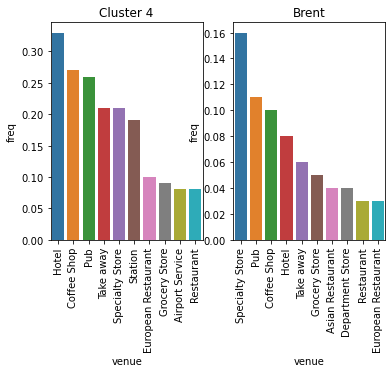

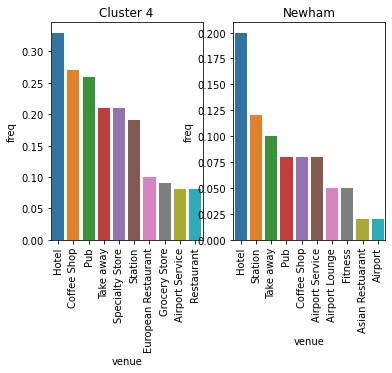

In [493]:
for i in cluster_4:
    compare_graph(cluster4_top10, i, 4)

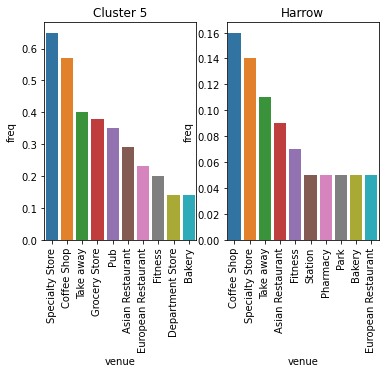

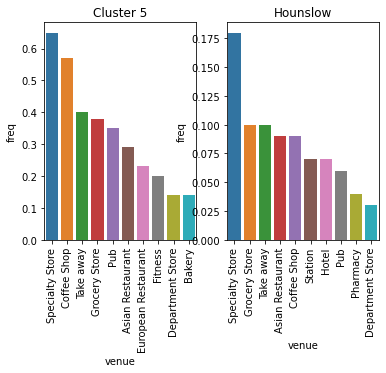

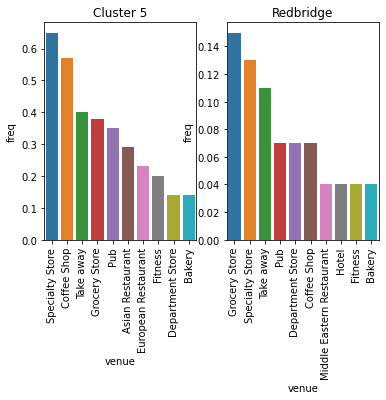

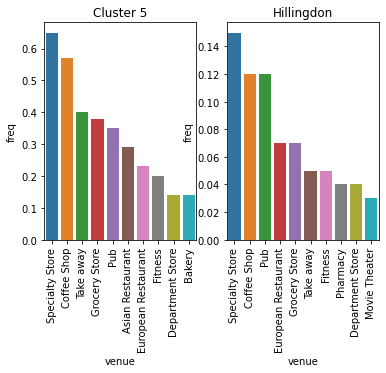

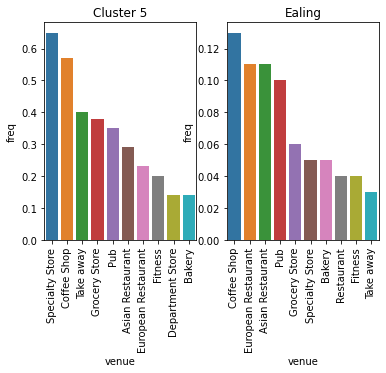

In [494]:
for i in cluster_5:
    compare_graph(cluster5_top10, i, 5)

## Discussion:
With the bar charts for comparison we can identify within each Borough, the best option for each of the developer's properties.

For instance, if we look at Cluster 1:
- Merton does not have a high frequency of Pubs compared to the cluster
- Barking and Dagenham does not have a high frequency of Pubs and Take away compared to the cluster
- Haringey does not have a high frequency of coffee shops and fitness centers compared to the cluster
- Waltham Forest does not have a high frequency of take away compared to the cluster
- Greenwich does not have a high frequency of European Restaurants and Grocery stores compared to the cluster
- Lewisham does not have a high frequency of Asian Restaurants and Fitness centers compared to the cluster
- Southwark does not have a high frequency of Take away and Asian Restaurants compared to the cluster
- Enfield does not have a high frequency of Take away and Asian Restaurants compared to the cluster
- Croydon does not have a high frequency of Fitness centers compared to the cluster

This comparison can be made by easily comparing the bar charts of the borough and the Cluster that borough falls within. We could then make a recommendation for all of the 33 boroughs in London.

## Conclusion:
The results show us the best venue types to open at each of the developers properties around London. Additional data could be collected on the residents of each Borough, along with building information on venues not listed (such as private office spaces), to help better improve the model. Overall the results are easy to identify and this report would be a good first step in identifying what business venues we should place at the developer's buildings.

